In [1]:
import numpy as np
from skimage import io
from veg_index import Image_Multi
import matplotlib.pyplot as plt
from matplotlib import path
import matplotlib.patches as patches
import georasters as gr

from scipy import misc
import math
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import Utils

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
im_red_path = "Barrack A/result_Red.tif"
im_green_path = "Barrack A//result_Green.tif"
im_blue_path = "Barrack A/result_Blue.tif"
im_nir_path = "Barrack A/result_NIR.tif"
im_rededge_path = "Barrack A/result_RedEdge.tif"

im_multi = Image_Multi(im_red_path, im_green_path, im_blue_path, im_nir_path, im_rededge_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

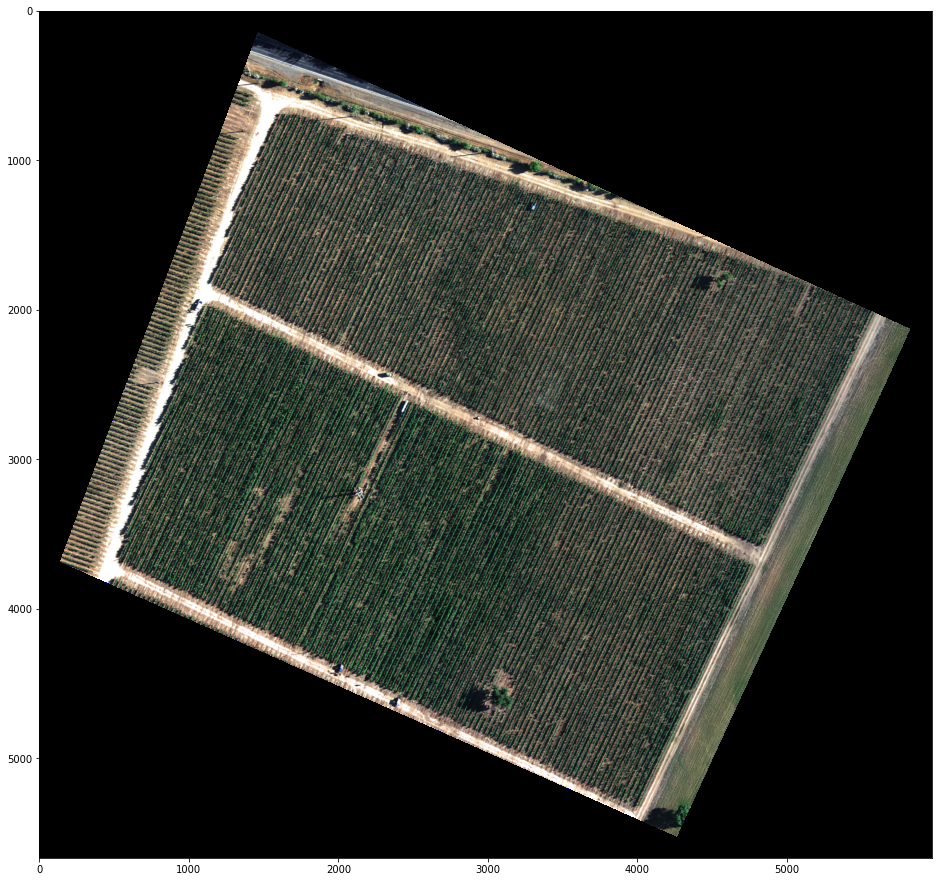

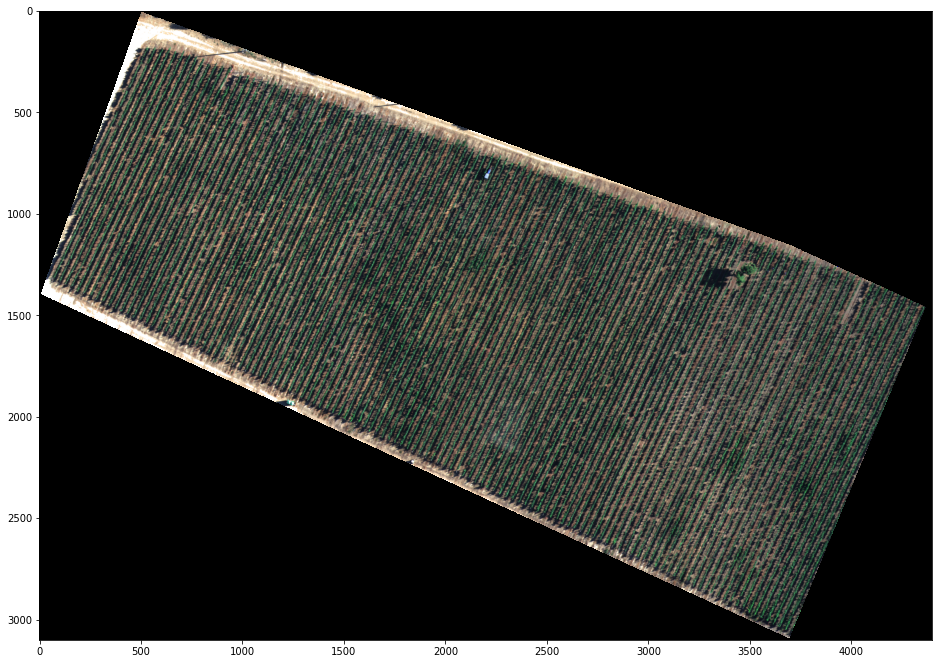

In [3]:
List_P = [(1100, 1900), (1600, 500), (5500, 1900), (4800, 3600)]
#List_P = [(500, 3700), (1000, 1900), (4900, 3500), (4000, 5500)]

im_multi_seg = im_multi.Segmentation(List_P)

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(im_multi.RGB().raster)
plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(im_multi_seg.RGB().raster)

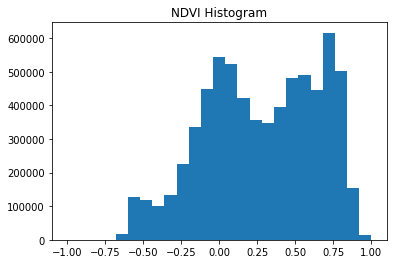

<Figure size 432x288 with 0 Axes>

In [37]:
NDVI_raster = im_multi_seg.NDVI().raster.copy()

plt.figure(1)
NDVI_raster = 2. * (NDVI_raster - np.ma.min(NDVI_raster)) / np.ma.ptp(NDVI_raster) - 1
plt.hist(NDVI_raster[~np.isnan(NDVI_raster)], bins = 25)
plt.title('NDVI Histogram')

plt.figure(2)
plt.figure(figsize=(16, 16))
plt.imshow(NDVI_raster > 0.3)

In [45]:
#NDVI_raster_bin = np.zeros((NDVI_raster.shape))
#NDVI_raster_bin = 255
thershold = 0.3
NDVI_raster_th = NDVI_raster > thershold
NDVI_raster_resize = NDVI_raster_th#[2000: 4000, 2000: 4000]
NDVI_raster_bin = np.ones((NDVI_raster_resize.shape))*0
NDVI_raster_bin[NDVI_raster_resize == 1] = 255

plt.figure(2)
plt.figure(figsize=(16, 16))
plt.imshow(NDVI_raster_bin)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

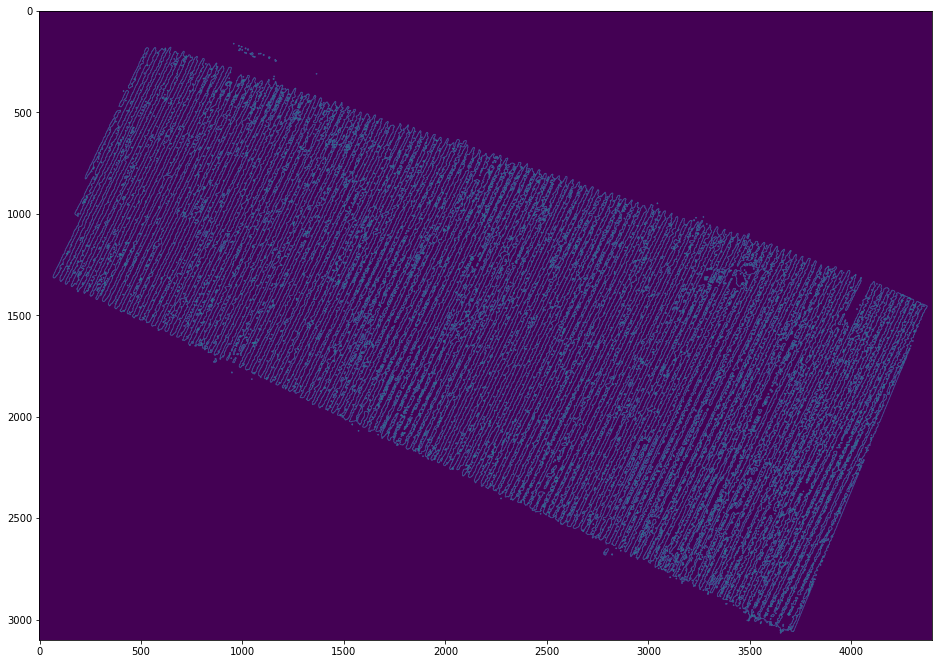

In [46]:
import cv2

NDVI_raster_bin_copy = NDVI_raster_bin.copy()


low_threshold = 100
high_threshold = 150

kernel_size = 5
blur_gray = cv2.GaussianBlur(NDVI_raster_bin,(kernel_size, kernel_size),2)
edges = cv2.Canny(np.uint8(blur_gray),low_threshold, high_threshold,apertureSize = 3)

height,width = edges.shape
skel = np.zeros([height,width],dtype=np.uint8)      #[height,width,3]
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
temp_nonzero = np.count_nonzero(edges)

while (np.count_nonzero(edges) != 0 ):
    eroded = cv2.erode(edges,kernel)
    #cv2.imshow("eroded",eroded)   
    temp = cv2.dilate(eroded,kernel)
    #cv2.imshow("dilate",temp)
    temp = cv2.subtract(edges,temp)
    skel = cv2.bitwise_or(skel,temp)
    edges = eroded.copy()
    
plt.figure(2) 
plt.figure(figsize=(16, 16))
plt.imshow(skel)

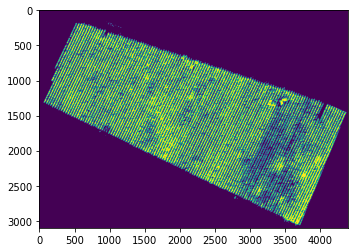

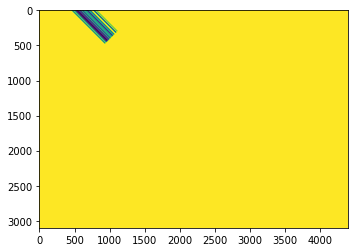

In [54]:
Z1 = np.ones((NDVI_raster_resize.shape))*255
Z2 = np.ones((NDVI_raster_resize.shape))*255



rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 100  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 10  # maximum gap in pixels between connectable line segments



lines = cv2.HoughLines(np.uint8(skel),rho, theta, threshold)
lines_P = cv2.HoughLinesP(np.uint8(skel),rho, theta, threshold, np.array([]) ,min_line_length, max_line_gap)

for line in lines[0:50]:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    #print((x1,y1,x2,y2))
    cv2.line(Z1,(x1,y1),(x2,y2),(0,0,255),2)
    
for line in lines_P:
    x1,y1,x2,y2 = line[0]
    cv2.line(Z2,(x1,y1),(x2,y2),(0,0,255),2)
    
plt.figure(1)    
plt.imshow(NDVI_raster_bin)   
plt.figure(3)   
plt.imshow(skel) 
plt.figure(5)    
plt.imshow(Z1)
plt.figure(6)    
plt.imshow(Z2)

(81578, 1, 2)
(355, 1, 4)


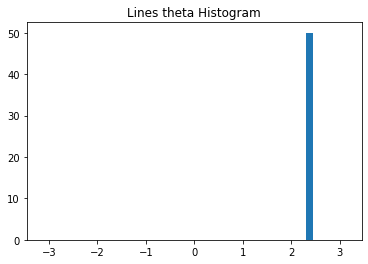

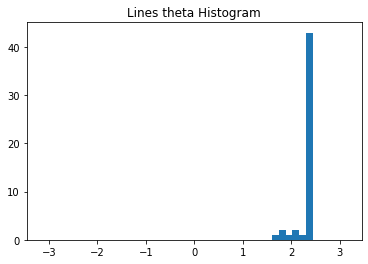

In [55]:
plt.figure(1)

plt.hist(lines[0:50,0,1], bins = 45, range=[-np.pi,np.pi])
plt.title('Lines theta Histogram')
print(lines.shape)

theta_P = [np.pi/2 + np.arctan2(line[0][3] - line[0][1],line[0][2]-line[0][0])  for line in lines_P[:50]]
plt.figure(2)
plt.hist(theta_P, bins = 45, range=[-np.pi,np.pi])
plt.title('Lines theta Histogram')
print(lines_P.shape)

In [9]:
print(np.pi/6)
print(np.pi/4)
print(np.pi/2 + np.pi/6)
print(np.pi/2 + np.pi/4)

0.5235987755982988
0.7853981633974483
2.0943951023931953
2.356194490192345


/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.


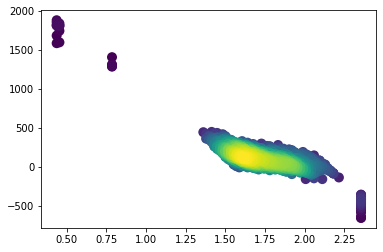

In [10]:
from scipy.stats import gaussian_kde
rho  = lines[0:1000, 0,0]
theta = lines[0:1000, 0,1]
xy = np.vstack([theta, rho])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
rho, theta, z = rho[idx], theta[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(theta, rho, c=z, s=100, edgecolor='')

plt.show()

plt.figure(2)
plt.hist2d(theta,rho,(50, 50), cmap=plt.cm.jet)

plt.colorbar() # show color scale


In [11]:
for line in lines_P:
    x1,y1,x2,y2 = line[0]
    cv2.line(Z,(x1,y1),(x2,y2),(0,0,255),50)
plt.figure(5)    
plt.imshow(Z)

NameError: name 'Z' is not defined

In [ ]:
lines= cv2.HoughLines(np.uint8(skel),rho, theta, threshold, )

In [ ]:
help(cv2.HoughLines)

In [28]:
lines.shape

(299, 1, 2)